In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

---------------------------

# Python Programming for Ocean Management: Real-time mapping of the fishing footprint in Atlantic Canada



Python Tutorial for Internation Ocean Institute (class 2018)

---------------------------

## Case study: Real-time mapping of the fishing footprint is support of concervation of North Atlantic Right 

---------------------------

### North Atlantic Right Whale (*Eubalaena glacialis*) - Only ~400 individuals left!

![alt text](images/rightwhalewdiver.jpg)

-----------------------

### Entaglement with fishing gear is one of the causes of mortality

![alt text](images/180201-eac-va-right-whale-entangled-sea-to-shore.jpg)

------------------------------

# VMS (Vessel Monitoring System)

Satellite trasnponder than many fishing vessels are required to carry.

![alt text](images/0000018_romtrax-wi-fi-vms_550.jpeg)

![alt text](images/vessel-monitoring-aid-kkp.jpg)



------------------
# Whale sightings

Take a look to `whale_sightings.csv`

In [2]:
import pandas as pd

whales = pd.read_csv('whale_sightings.csv')

whales

Date  Latitude  Longitude  Number of right whales
0  2018-05-31  47.59990 -64.098750                       1
1  2018-05-27  48.15185 -63.381437                       1
2  2018-05-24  44.58650 -63.058000                       1
3  2018-05-24  44.63517 -62.678800                       1


------------------
### Very basic "mapping" (non projected) of whale data


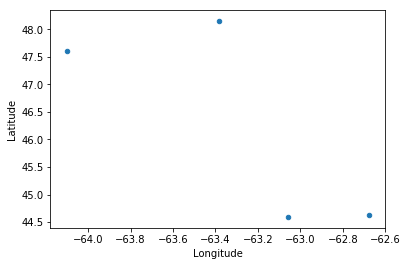

In [3]:
whales.plot(x='Longitude',y='Latitude',kind='scatter')

------------------
### "Projected" mapping of whale data: Adding land


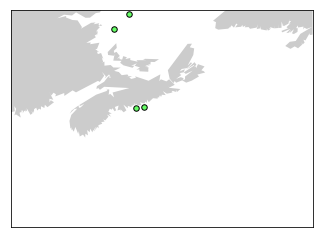

In [4]:
from mpl_toolkits.basemap import Basemap

# Create map
m = Basemap(projection='mill',
            llcrnrlat=39.9,
            urcrnrlat=48.3,
            llcrnrlon=-69,
            urcrnrlon=-54.7,
            resolution='l')

x, y = m(whales['Longitude'].values,whales['Latitude'].values)

cs = m.scatter(x,y,s=30,marker='o',color='#66ff66', edgecolor='k')

m.fillcontinents()

### Packaging of mapping code iito a "Function" for easy reuse

In [5]:
def make_basemap():    
    from mpl_toolkits.basemap import Basemap

    # Create map
    m = Basemap(projection='mill',
                llcrnrlat=39.9,
                urcrnrlat=48.3,
                llcrnrlon=-69,
                urcrnrlon=-54.7,
                resolution='l')
    
    m.fillcontinents()
    return m



def plot_whales(whales, m):    
    x, y = m(whales['Longitude'].values,whales['Latitude'].values)

    cs = m.scatter(x,y,s=60,marker='o',color='#66ff66', edgecolor='k',zorder=50)
    return

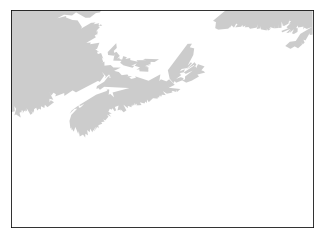

In [6]:
make_basemap()

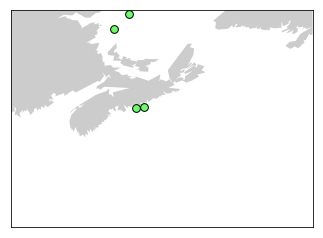

In [7]:
make_basemap()
plot_whales(whales, m)

### Tweaking our "Function" to make a nicer basemap

In [8]:
def make_basemap():
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    
    fig1 = plt.figure(figsize=(13,10))

    # Create map
    m = Basemap(projection='mill',
                llcrnrlat=39.9,
                urcrnrlat=48.3,
                llcrnrlon=-69,
                urcrnrlon=-54.7,
                resolution='i')
    
    m.drawcoastlines(color='#a6a6a6',linewidth=0.5,zorder=42)
    m.fillcontinents(color='#e6e6e6',zorder=42)
    m.drawmapboundary()
    plt.tight_layout()
    return m

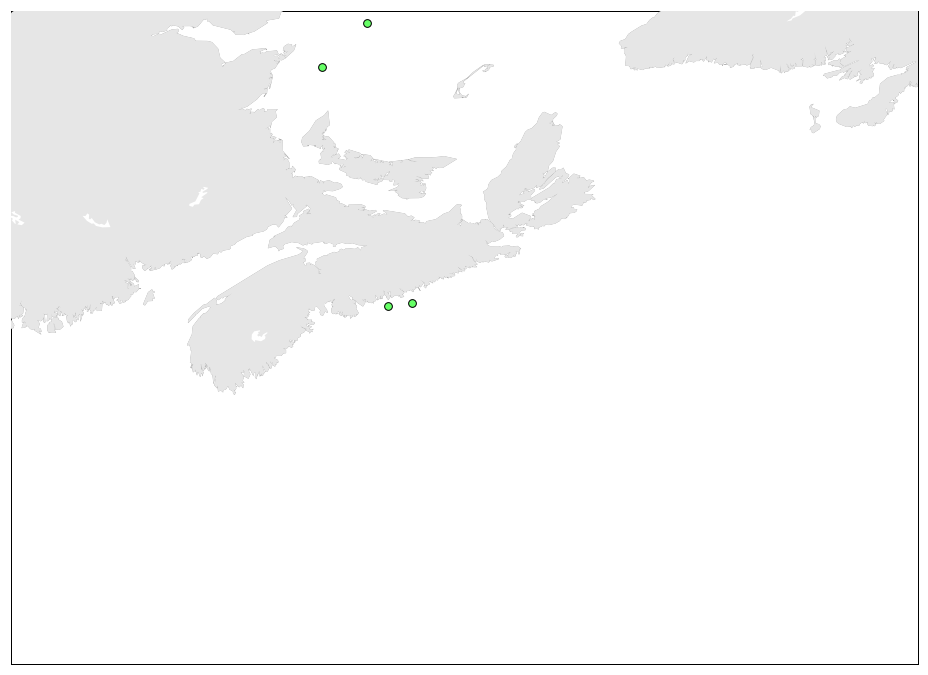

In [9]:
m = make_basemap()
plot_whales(whales, m)

<IPython.core.display.Javascript object>


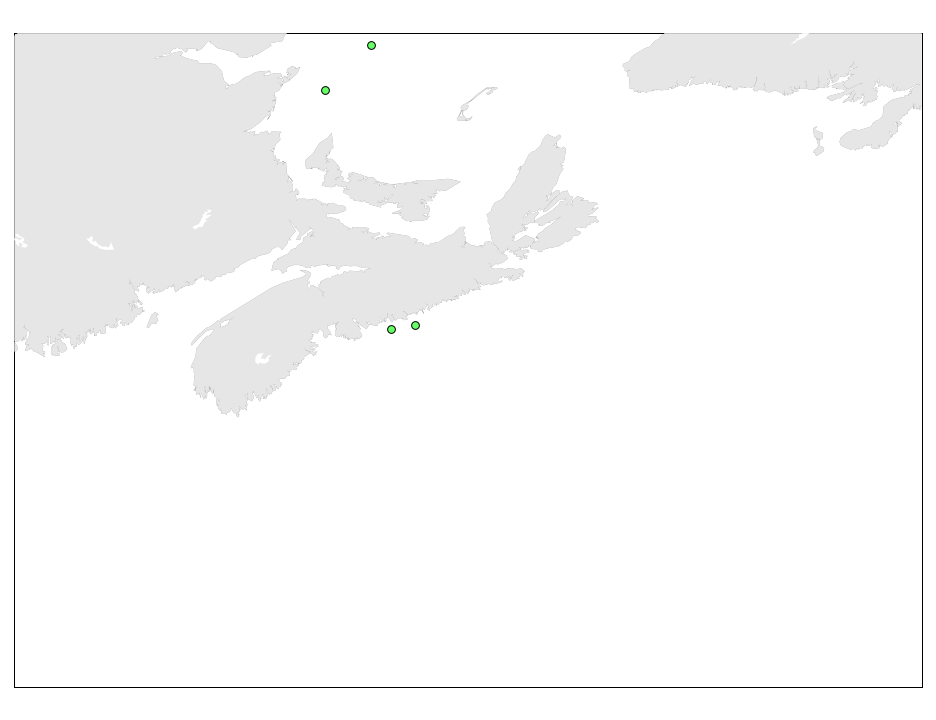

In [23]:
%matplotlib notebook
m = make_basemap()
plot_whales(whales, m)

----------------------
## Importing functions from an external file (i.e. `my_fucntions.py`):

### Adding the "Maritimes Region" polygon

<IPython.core.display.Javascript object>


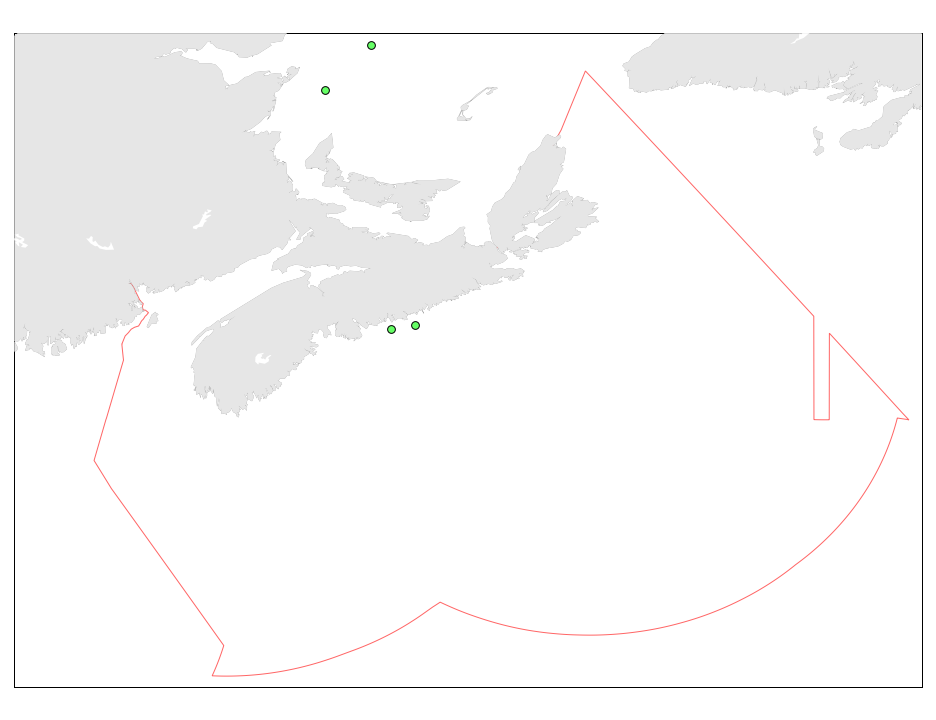

In [24]:
import my_functions as mf

m = make_basemap()
plot_whales(whales, m)

mf.add_maritimes_region(m)

----------------------

### Adding the "NAFO subregions" polygons

<IPython.core.display.Javascript object>


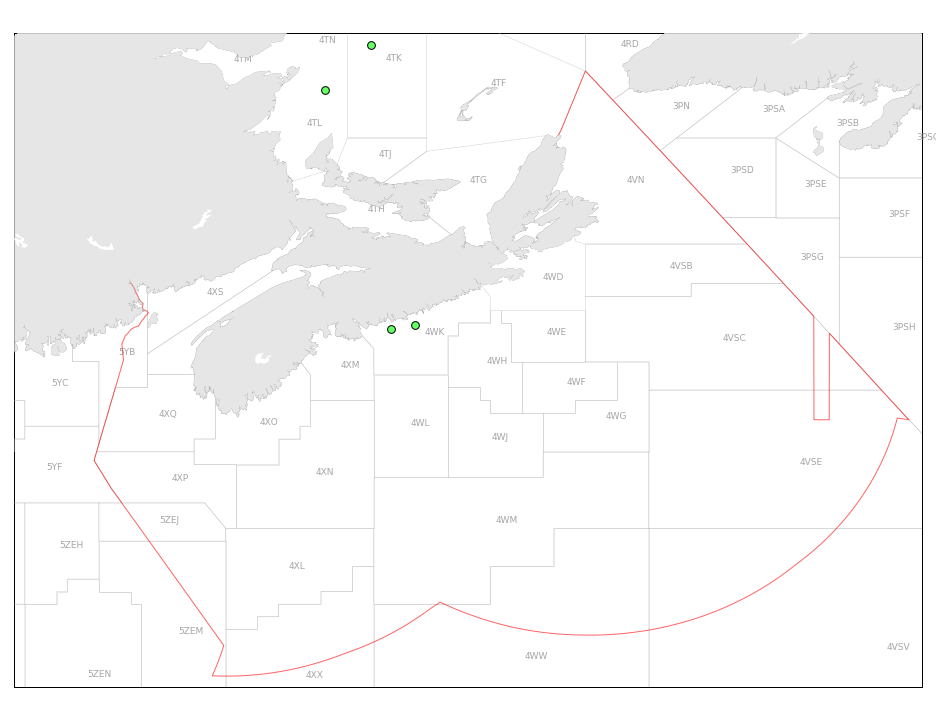

In [25]:
m = make_basemap()
plot_whales(whales,m)
mf.add_maritimes_region(m)
mf.add_NAFO_areas(m)

----------------------

### Make a function to download bathymetry (from ERDDAP server) 


In [26]:
def add_bathymetry(m):
    import matplotlib.pyplot as plt
    import netCDF4
    import urllib.request
    import numpy as np
    bathymetry_file = 'usgsCeSrtm30v6.nc'

    minlat=39.9
    maxlat=48.3
    minlon=-69
    maxlon=-54.7
    
    isub = 1
    base_url='http://coastwatch.pfeg.noaa.gov/erddap/griddap/usgsCeSrtm30v6.nc?'
    query='topo[(%f):%d:(%f)][(%f):%d:(%f)]' % (maxlat,isub,minlat,minlon,isub,maxlon)
    url = base_url+query
    # store data in NetCDF file
    urllib.request.urlretrieve(url, bathymetry_file)

    # open NetCDF data in
    nc = netCDF4.Dataset(bathymetry_file)
    ncv = nc.variables
    lon = ncv['longitude'][:]
    lat = ncv['latitude'][:]
    lons, lats = np.meshgrid(lon, lat)
    topo = ncv['topo'][:, :]
    
    TOPOmasked = np.ma.masked_where(topo>0,topo)

    # For topo
    x, y = m(lons, lats)
    plt.pcolormesh(x,y,TOPOmasked,cmap=plt.get_cmap('Blues_r'),zorder=5,vmax=2000)

    depth_levels_1 = np.linspace(topo.min(), -700, num=5)

    depth_levels = np.append(depth_levels_1,np.linspace(-650, -50, num=15))

    depth_levels = depth_levels.tolist()

    cs = plt.contour(
        x,
        y,
        topo,
        depth_levels,
        cmap=plt.get_cmap('Blues_r'),
        linewidths=0.3,
        linestyles='solid',
        zorder=19)
    return

<IPython.core.display.Javascript object>


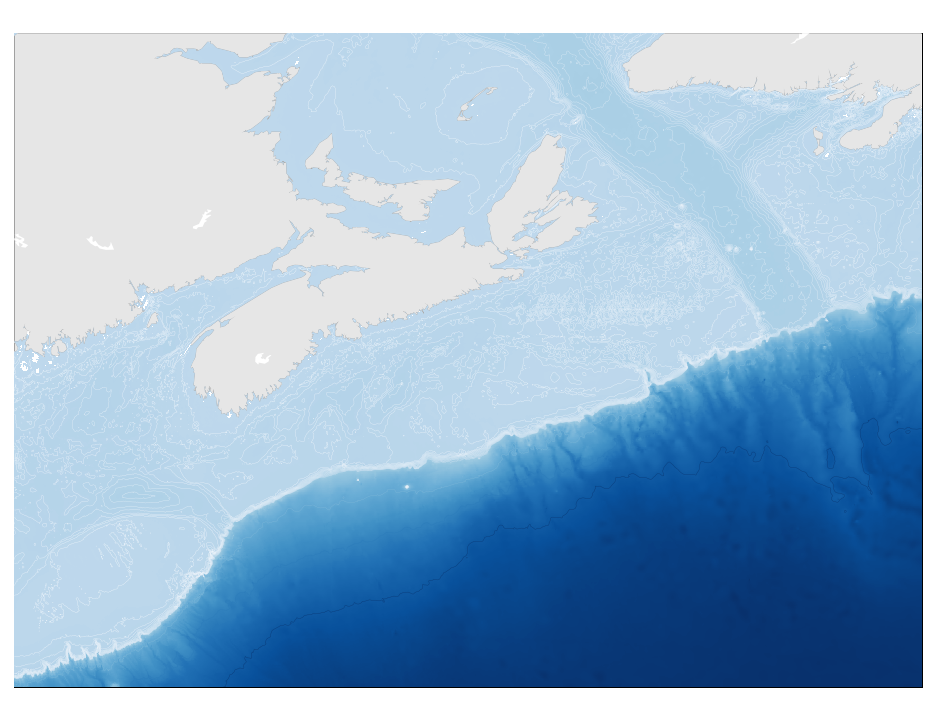

In [27]:
m = make_basemap()
add_bathymetry(m)

---------------

## Make basemap and "pickle" it for WAY FASTER display in future plots 


<IPython.core.display.Javascript object>


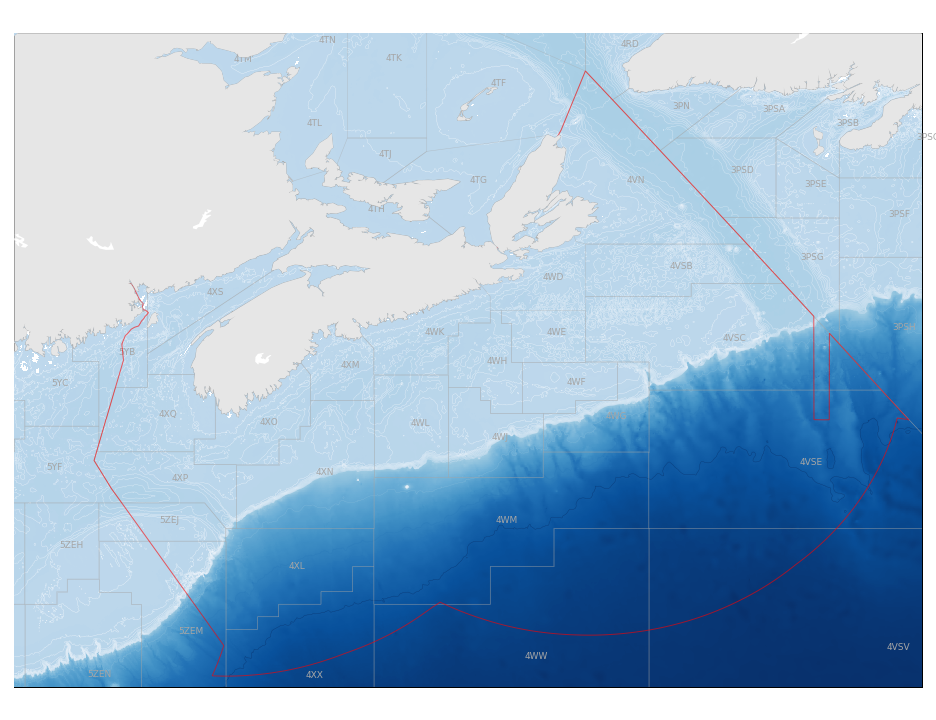

In [28]:
import _pickle as pickle

m = make_basemap()

mf.add_maritimes_region(m)
mf.add_NAFO_areas(m)
add_bathymetry(m)

pickle.dump(m, open('basemap.p', 'wb'), -1)

--------------

### Test our new "fast-loading" pickled basemap

<IPython.core.display.Javascript object>


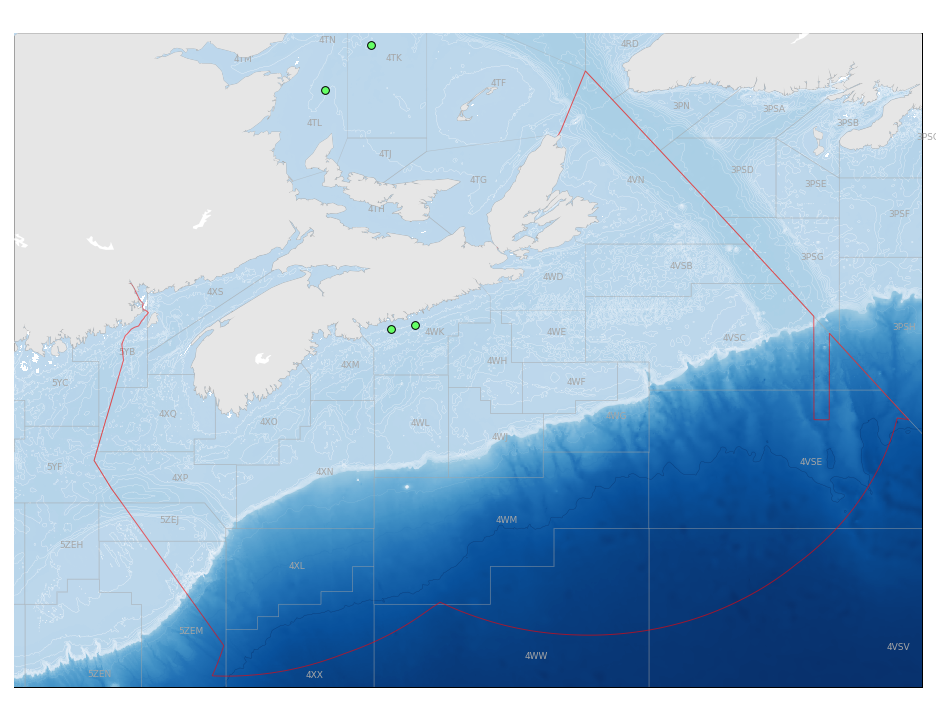

In [29]:
m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)


------------------
# Fishing footprint (VMS)

![alt text](images/Longline-3.jpg)


In [18]:
vms_csv = 'vms_autoDownloaded.csv'

fishing_ships = pd.read_csv(vms_csv)

fishing_ships

VR_NUMBER   LATITUDE  LONGITUDE    POSITION_UTC_DATE
0         105912  42.083000 -66.652000  2018-05-25 06:00:01
1         106604  42.130820 -66.917840  2018-05-25 06:00:01
2         107314  43.441650 -65.208410  2018-05-25 06:00:01
3         101019  43.744230 -65.317730  2018-05-25 06:00:01
4         100247  44.477891 -63.600112  2018-05-25 06:00:01
5         107918  44.478235 -63.599082  2018-05-25 06:00:01
6         103677  44.632472 -65.747166  2018-05-25 06:00:01
7         104994  44.729118 -63.008567  2018-05-25 06:00:01
8           7488  44.736580 -62.830900  2018-05-25 06:00:01
9         106311  44.907302 -65.867158  2018-05-25 06:00:01
10        103394  44.943523 -66.920558  2018-05-25 06:00:01
11        106991  44.949290 -65.265530  2018-05-25 06:00:01
12        107553  45.011210 -58.887130  2018-05-25 06:00:01
13        108065  45.053987 -66.798592  2018-05-25 06:00:01
14        103923  45.122180 -66.351250  2018-05-25 06:00:01
15        107204  45.231490 -60.181800  2018-05-25 06:00:01
16        106050  45.274228 -66.068259  2018-05-25 06:00:01
17        102680  45.338970 -60.997130  2018-05-25 06:00:01
18        108358  45.339031 -60.995494  2018-05-25 06:00:01
19        138113  45.339288 -60.997811  2018-05-25 06:00:01
20        108292  45.580558 -64.952632  2018-05-25 06:00:01
21        108029  45.582410 -60.740260  2018-05-25 06:00:01
22        104917  45.717170 -60.245190  2018-05-25 06:00:01
23        161024  45.899505 -59.976769  2018-05-25 06:00:01
24        106683  45.920440 -59.967890  2018-05-25 06:00:01
25        160602  46.006364 -59.840642  2018-05-25 06:00:01
26        158986  46.873420 -62.974880  2018-05-25 06:00:02
27         18437  45.338600 -60.995500  2018-05-25 06:00:15
28        104735  44.476740 -63.602280  2018-05-25 06:00:32
29        107181  44.482680 -63.594540  2018-05-25 06:00:32
...          ...        ...        ...                  ...
56354     153378  46.996164 -62.534180  2018-06-01 05:30:00
56355      12258  48.258670 -63.847730  2018-06-01 05:30:05
56356     139941  47.889180 -60.797340  2018-06-01 05:30:40
56357     103094  47.302890 -63.320260  2018-06-01 05:31:01
56358     153752  46.467000 -55.124000  2018-06-01 05:35:00
56359     153378  46.996850 -62.534695  2018-06-01 05:35:00
56360      12258  48.261970 -63.857830  2018-06-01 05:35:05
56361     153378  46.997451 -62.535296  2018-06-01 05:40:00
56362      12258  48.265280 -63.867930  2018-06-01 05:40:05
56363     151824  46.917500 -55.391000  2018-06-01 05:43:00
56364     133060  46.899003 -55.371094  2018-06-01 05:45:00
56365     153378  46.998052 -62.535897  2018-06-01 05:45:00
56366      12258  48.268470 -63.878030  2018-06-01 05:45:05
56367     139941  47.909160 -60.830460  2018-06-01 05:45:36
56368     103094  47.280660 -63.284970  2018-06-01 05:46:01
56369     153378  46.998653 -62.536412  2018-06-01 05:50:00
56370      12258  48.272280 -63.889030  2018-06-01 05:50:05
56371     153378  46.999254 -62.537013  2018-06-01 05:55:00
56372      12258  48.275180 -63.898130  2018-06-01 05:55:05
56373     100989  44.374894 -64.308558  2018-06-01 06:00:00
56374     131668  44.481300 -63.582370  2018-06-01 06:00:00
56375       5706  45.000000 -65.000000  2018-06-01 06:00:00
56376     155586  46.307910 -55.369960  2018-06-01 06:00:00
56377     102861  46.374290 -55.251230  2018-06-01 06:00:00
56378      84067  46.412700 -55.651810  2018-06-01 06:00:00
56379     137936  46.446570 -56.843030  2018-06-01 06:00:00
56380     101174  46.916700 -55.390130  2018-06-01 06:00:00
56381     153378  46.999854 -62.537614  2018-06-01 06:00:00
56382       5666  47.074441 -55.829001  2018-06-01 06:00:00
56383      94141  47.463400 -58.939490  2018-06-01 06:00:00

[56384 rows x 4 columns]

------------------
### Open basemap, plot VMS fishing "pings"


<IPython.core.display.Javascript object>


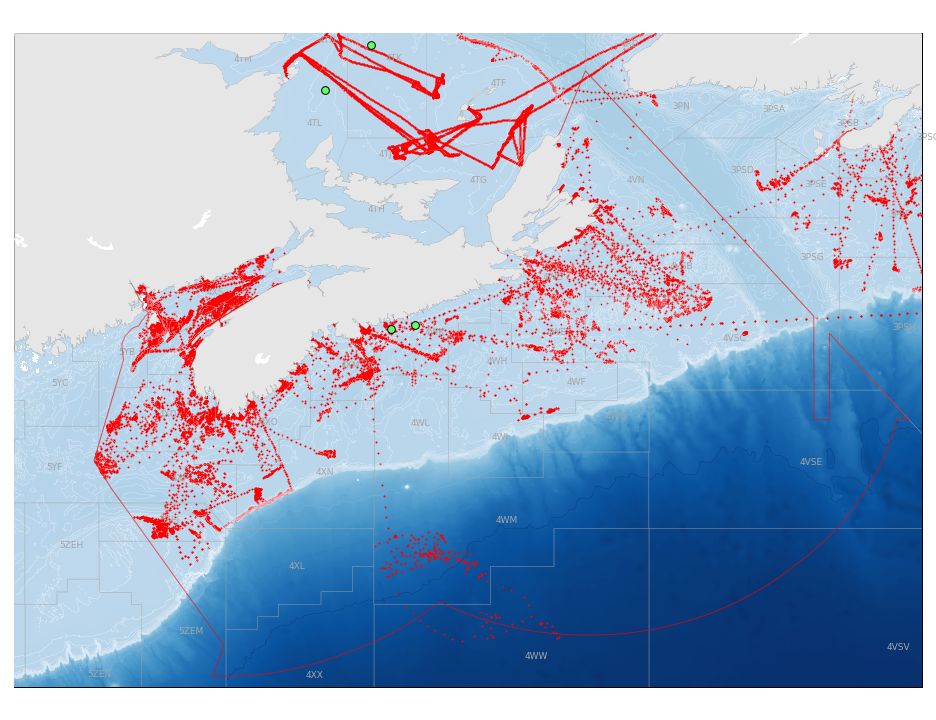

In [30]:
import matplotlib.pyplot as plt

m = pickle.load(open('basemap.p','rb'))

# Change Lat/Lons into proyected x/y coordinates
x, y = m(fishing_ships['LONGITUDE'].values,fishing_ships['LATITUDE'].values)

plt.scatter(x,y,s=1,marker='o',color='r', zorder=10)

plot_whales(whales,m)

In [31]:
def make_heatmap(info, m, data):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    x = np.arange(info['minlon'], info['maxlon'], info['bin_size'], dtype=np.float64)
    y = np.arange(info['minlat'], info['maxlat'], info['bin_size'], dtype=np.float64)
    
    info['bin_number'] = (np.ceil((info['maxlon'] - info['minlon'])/info['bin_size']),
                            np.ceil((info['maxlat'] - info['minlat'])/info['bin_size']))
    
    x,y = m(data['LONGITUDE'].values, data['LATITUDE'].values)
    
    H, xedges, yedges = np.histogram2d(x,y,bins=300)
    # Rotate and flip H...
    H = np.rot90(H)
    H = np.flipud(H)
     
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H)
     
    # Log H for better display
    Hmasked = np.log10(Hmasked)
     
    # Make map
    cs = m.pcolor(xedges,yedges,Hmasked,cmap=plt.get_cmap('inferno_r'), zorder=49)
    
    return

<IPython.core.display.Javascript object>


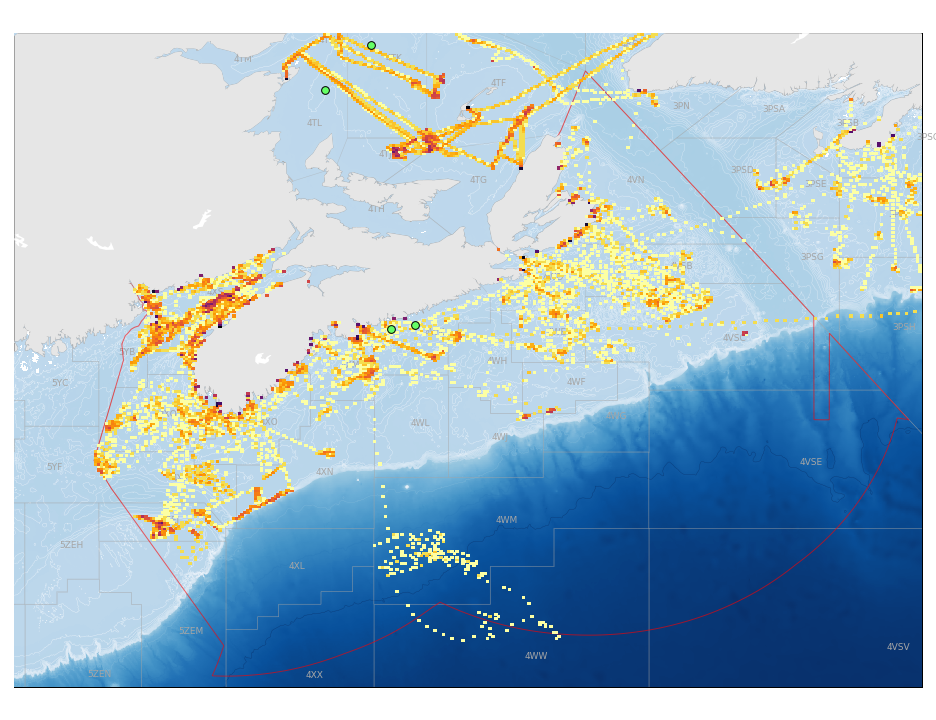

In [32]:
#from gridder import make_heatmap

info = {}
info['minlat'] = 39.9
info['maxlat'] = 48.3
info['minlon'] = -69
info['maxlon'] = -54.7
info['bin_size'] = 0.01 # Degrees

m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)

make_heatmap(info, m, fishing_ships)


------------------
## Filter `fishing_ships` data by speed

Note that - when fishing - vessels usually travel between 0.5 and 4.5 knots

### First, we have to estimate "speed"

In [34]:
from datetime import datetime
import numpy as np
import my_functions as mf

VR_NUMBER, LATITUDE, LONGITUDE, POSITION_UTC_DATE, SPEED_KNOTS = [],[],[],[],[]

unis = pd.unique(fishing_ships['VR_NUMBER'])

for ship in unis:
    singleship = fishing_ships[fishing_ships['VR_NUMBER'] == ship].reset_index()
    
    if len(singleship) > 1:
    
        for i in range(1,len(singleship)):

            startdate = datetime.strptime(singleship['POSITION_UTC_DATE'][i-1], '%Y-%m-%d %H:%M:%S')
            enddate = datetime.strptime(singleship['POSITION_UTC_DATE'][i], '%Y-%m-%d %H:%M:%S')

            elapsed_time = enddate-startdate
            elapsed_distance = mf.distance(singleship['LATITUDE'][i-1],
                                        singleship['LONGITUDE'][i-1],
                                        singleship['LATITUDE'][i],
                                        singleship['LONGITUDE'][i]) / 1852
            
            if elapsed_time.seconds > 0:
                speed = elapsed_distance / (elapsed_time.seconds / 3600)
            else:
                speed = np.nan

            VR_NUMBER.append(singleship['VR_NUMBER'][i])
            LATITUDE.append(singleship['LATITUDE'][i])
            LONGITUDE.append(singleship['LONGITUDE'][i])
            POSITION_UTC_DATE.append(singleship['POSITION_UTC_DATE'][i])
            SPEED_KNOTS.append(speed)

new_fishing_ships = pd.DataFrame({'VR_NUMBER':VR_NUMBER,
                        'LATITUDE':LATITUDE,
                        'LONGITUDE':LONGITUDE,
                        'POSITION_UTC_DATE':POSITION_UTC_DATE,
                        'SPEED_KNOTS':SPEED_KNOTS})
   

Note that `new_fishing_ships` has an extra column named `SPEED_KNOTS`

In [ ]:
new_fishing_ships 

<IPython.core.display.Javascript object>


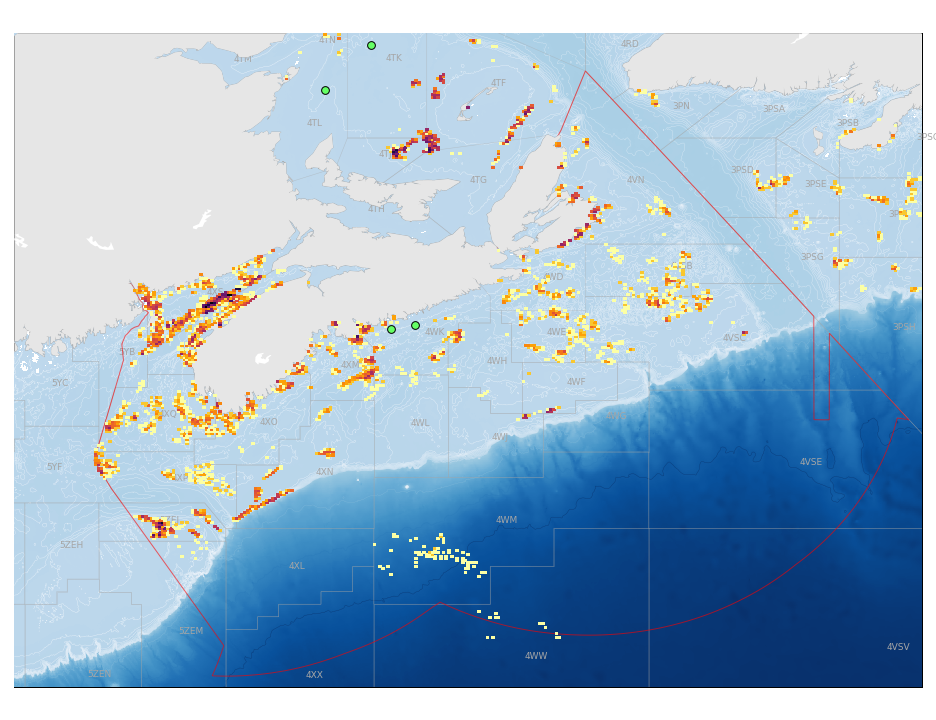

In [35]:
myFilter = (new_fishing_ships['SPEED_KNOTS']>0.5) & (new_fishing_ships['SPEED_KNOTS']<4.5)

fishing3 = new_fishing_ships[myFilter]

m = pickle.load(open('basemap.p','rb'))

plot_whales(whales,m)

make_heatmap(info, m, fishing3)

------------------

# Set stage
whales get entangled


Whales get sotted by planes, ships, and gliders.


https://environmental-action.org/wp-content/uploads/2018/02/180201-eac-va-right-whale-entangled-sea-to-shore.jpg

https://whalesandmarinefauna.files.wordpress.com/2013/01/628x471_004.jpg

http://mediad.publicbroadcasting.net/p/mpbn/files/styles/x_large/public/201805/12683617055_5f20872e81_k.jpg

https://media.mnn.com/assets/images/2017/12/TangledNorthAtlanticRightWhale.jpg




spoter planes
https://pbs.twimg.com/media/DdVa8ltX0AEo10V.jpg

https://assets.skiesmag.com/images/online/MaritimeProtector/1.jpg

https://assets.skiesmag.com/images/online/MaritimeProtector/4.jpg

http://www.releases.gov.nl.ca/releases/2013/fishaq/1216n04_pic.jpg

https://ssl.c.photoshelter.com/img-get2/I0000jNrkh7emj4Q/fit=1000x750/GSBCAN0401005.jpg

https://cdn.planespotters.net/photo/131000/original/c-gcfj-canada-transport-canada-de-havilland-canada-dhc-8-102-dash-8_PlanespottersNet_131307_cbd5848763.jpg

http://imgproc.airliners.net/photos/airliners/5/7/1/2711175.jpg?v=v40


https://twitter.com/FishOceansCAN/status/991054848538923008



Spoter vessels
CCGS Corporal McLaren M.M.V.
https://navaltoday.com/wp-content/uploads/2015/05/Canadian-Coast-Guard-Expands-Fleet.jpg

http://www.ccg-gcc.gc.ca/Vessel-Procurement/Gallery

------------------

------------------

Present the data (I think it is better to do this bit by bit... present each data set just before it is used)

- VMS data
http://cawebstore.romcomm.com/romtrax-wi-fi-vms-2

https://www.google.ca/imgres?imgurl=http%3A%2F%2Fsahabatmancing.com%2Fwp-content%2Fuploads%2F2017%2F08%2Fvessel-monitoring-aid-kkp.jpg&imgrefurl=http%3A%2F%2Fsahabatmancing.com%2Fupdates%2Fkkp-kini-punya-alat-pantau-kapal-perikanan-secara-real-time%2F&docid=G33MUa4MuPLA0M&tbnid=s3lhl5EeLQVv9M%3A&vet=1&w=800&h=444&bih=984&biw=1920&ved=2ahUKEwjhz_DLubLbAhUMzoMKHbBdDvIQxiAoA3oECAEQFw&iact=c&ictx=1

- WHale possitions

- PLane surveys

- Glider surveys

------------------